## Set Up Date Parameters

In [1]:
# simple parameters
start_date = "01/04/2016"
end_date = "09/30/2016"

## PyAlgoFeed Customized Class

In [2]:
from pyalgotrade.barfeed import common
from pyalgotrade.utils import dt
from pyalgotrade import bar
from pyalgotrade import dataseries
from pyalgotrade.barfeed import csvfeed

class Feed(csvfeed.BarFeed):
    """A :class:`pyalgotrade.barfeed.csvfeed.BarFeed` that loads bars from CSV files downloaded from Yahoo! Finance.

    :param frequency: The frequency of the bars. Only **pyalgotrade.bar.Frequency.DAY** or **pyalgotrade.bar.Frequency.WEEK**
        are supported.
    :param timezone: The default timezone to use to localize bars. Check :mod:`pyalgotrade.marketsession`.
    :type timezone: A pytz timezone.
    :param maxLen: The maximum number of values that the :class:`pyalgotrade.dataseries.bards.BarDataSeries` will hold.
        Once a bounded length is full, when new items are added, a corresponding number of items are discarded from the opposite end.
    :type maxLen: int.

    .. note::
        Yahoo! Finance csv files lack timezone information.
        When working with multiple instruments:

            * If all the instruments loaded are in the same timezone, then the timezone parameter may not be specified.
            * If any of the instruments loaded are in different timezones, then the timezone parameter must be set.
    """

    def __init__(self, frequency=bar.Frequency.DAY, timezone=None, maxLen=dataseries.DEFAULT_MAX_LEN):
        if isinstance(timezone, int):
            raise Exception("timezone as an int parameter is not supported anymore. Please use a pytz timezone instead.")

        if frequency not in [bar.Frequency.DAY, bar.Frequency.WEEK]:
            raise Exception("Invalid frequency.")

        csvfeed.BarFeed.__init__(self, frequency, maxLen)
        self.__timezone = timezone
        self.__sanitizeBars = False

    def sanitizeBars(self, sanitize):
        self.__sanitizeBars = sanitize

    def barsHaveAdjClose(self):
        return True
    
    def addBarsFromSpxArray(self, instrument, timeseries, timezone=None):
        loadedBars = []
                
        for entry in timeseries:
            dateTime = datetime.datetime.strptime(entry['Date'], '%Y-%m-%d') #2016-09-02
            price = entry['Closed']
            close = price
            open_ = price
            high = price
            low = price
            volume = 0
            adjClose = price
            
            currentBar = bar.BasicBar(dateTime, open_, high, low, close, volume, adjClose, self.getFrequency())
            loadedBars.append(currentBar)
  
        self.addBarsFromSequence(instrument, loadedBars)
    
    def addBarsFromArray(self, instrument, array, timezone=None):
        loadedBars = []
        
        def get_date(entry):
            return datetime.datetime.strptime(entry['DateType'], '%m/%d/%Y') #01/19/2018
        
        for entry in array:
            dateTime = get_date(entry)
            mid = ( float(entry["Ask"]) + float(entry["Bid"]) ) / 2
            close = mid
            open_ = mid
            high = float(entry["Ask"])
            low = float(entry["Bid"])
            volume = int(entry["Volume"])
            adjClose = mid
            
            currentBar = bar.BasicBar(dateTime, open_, high, low, close, volume, adjClose, self.getFrequency())
            loadedBars.append(currentBar)
  
        self.addBarsFromSequence(instrument, loadedBars)

    def addBarsFromCSV(self, instrument, path, timezone=None):
        """Loads bars for a given instrument from a CSV formatted file.
        The instrument gets registered in the bar feed.

        :param instrument: Instrument identifier.
        :type instrument: string.
        :param path: The path to the CSV file.
        :type path: string.
        :param timezone: The timezone to use to localize bars. Check :mod:`pyalgotrade.marketsession`.
        :type timezone: A pytz timezone.
        """

        if isinstance(timezone, int):
            raise Exception("timezone as an int parameter is not supported anymore. Please use a pytz timezone instead.")

        if timezone is None:
            timezone = self.__timezone

        rowParser = RowParser(self.getDailyBarTime(), self.getFrequency(), timezone, self.__sanitizeBars)
        csvfeed.BarFeed.addBarsFromCSV(self, instrument, path, rowParser)

## Yahoo Historical Data -> Pandas

In [3]:
import datetime
import urllib2


def get_yahoo_historical_pandas(instrument, start_date_str, end_date_str):
    """Returns a historical dataframe .

    Args:
        instrument: the ticker symbol
        start_date_str: the start date in MM/DD/YYYY format
        end_date_str: the end date in MM/DD/YYYY format
    """
    
    start_date = datetime.datetime.strptime(start_date_str, "%m/%d/%Y")
    end_date = datetime.datetime.strptime(end_date_str, "%m/%d/%Y")
    
    start_date_month = str(start_date.month - 1) #Yahoo Finance month counts from zero
    end_date_month = str(end_date.month -1)
    
    start_date_day = str(start_date.day)
    start_date_year = str(start_date.year)
    
    end_date_day = str(end_date.day)
    end_date_year = str(end_date.year)
    
    # Import SPX time series
    url = 'http://chart.finance.yahoo.com/table.csv?s=' + instrument + '&a=' + start_date_month + '&b=' + start_date_day + '&c=' + start_date_year + "&d=" + end_date_month + '&e=' + end_date_day + '&f=' + end_date_year + '&g=d&ignore=.csv'
    
    # Import SPX time series
    response = urllib2.urlopen(url)
    html = response.read()
    html_processed = "\n".join(html.split("\n")[1:])
    timed_entries = []

    for line in html_processed.split("\n"):
        columns = line.split(",")
        date = columns[0]
        close = columns[-1]
    
        if date != '':
            timed_entries.append({'Date':date, 'Closed':close})

    def get_date(entry):
        return datetime.datetime.strptime(entry['Date'], '%Y-%m-%d')

    sorted_timed_entries = sorted(timed_entries, key=lambda entry:get_date(entry))
    return sorted_timed_entries

## Historical Option Parser -> The Format of Options Historical Data

```
UnderlyingSymbol,UnderlyingPrice,Exchange,OptionRoot,OptionExt,Type,Expiration,DataDate,Strike,Last,Bid,Ask,Volume,OpenInterest,T1OpenInterest
A,46.99,*,A180119P00065000,,put,01/19/2018,09/01/2016,65,0,16.95,20.15,0,0,0
```

The sketch is for each day, figure out SPX's ATM and near the money option chain. From there, construct a dictionary of dataframes. From there, we add all of the dataframes to a PyAlgoTrade Feed.

In [21]:
import zipfile

def parse_csv_entry(line):
    columns = line.split(",")
    opt_symbol = columns[3]
    opt_type = columns[5]
    expiration = columns[6]
    data_date = columns[7]
    strike = columns[8]
    last = columns[9]
    bid = columns[10]
    ask = columns[11]
    #volume = columns[12]
    volume = 2000 # hard-code the volume to make the options tradeable
    
    return {"Symbol": opt_symbol, "DateType": data_date, "Type": opt_type, "ExpDate": expiration, "Strike": strike, "Last": last, "Bid": bid, "Ask": ask, "Volume": volume}

def get_historical_option_iterator(f, instrument):
    last_line = None
    for line in f:        
        if line.startswith(instrument + ","):
            last_line = line 
            break
            
    while True and last_line.startswith(instrument + ","):
        yield parse_csv_entry(last_line)
        last_line = f.readline()

def parse_historical_single_option(csv_file, instrument):
    entries = {}
    
    f = open(csv_file)
    i = 0
    for line in f:
        entry = parse_csv_entry(line)
        current_bar = entry
        opt_symbol = current_bar['Symbol']
        
        if opt_symbol not in entries.keys():
            entries[opt_symbol] = [current_bar]
        else:
            entries[opt_symbol].append(current_bar)
        
        i = i + 1
        
        if i % 50000 == 0:
            print current_bar
            print "Parsing: " + str(i)
    
    f.close()
    return entries

def parse_historical_option_data(zip_file):
    entries = {}
    
    with zipfile.ZipFile(zip_file, 'r') as myzip:
        for day_file in myzip.namelist():
            print "FileName:" + day_file
            f = myzip.open(day_file)
            line = f.readline()
            it = get_historical_option_iterator(f, "SPX")
        
            for entry in it:
                current_bar = entry
                opt_symbol = current_bar['Symbol']
        
                if opt_symbol not in entries.keys():
                    entries[opt_symbol] = [current_bar]
                else:
                    entries[opt_symbol].append(current_bar)
    
    return entries

def process_historical_option_data(zip_file):
    def get_date(entry):
        return datetime.datetime.strptime(entry['DateType'], '%m/%d/%Y') #01/19/2018
    
    entries = parse_historical_option_data(zip_file)

    for opt_symbol in entries.keys():
        time_series = entries[opt_symbol]
        sorted_time_series = sorted(time_series, key=lambda entry:get_date(entry))
        entries[opt_symbol] = sorted_time_series
    
    return entries

def process_historical_single_option_data(csv_file, instrument):
    def get_date(entry):
        return datetime.datetime.strptime(entry['DateType'], '%m/%d/%Y') #01/19/2018
    
    entries = parse_historical_single_option(csv_file, instrument)

    for opt_symbol in entries.keys():
        time_series = entries[opt_symbol]
        sorted_time_series = sorted(time_series, key=lambda entry:get_date(entry))
        entries[opt_symbol] = sorted_time_series
    
    return entries

## Naked Strangle Option Strategy

In [22]:
from pyalgotrade import strategy
from vollib.black_scholes.implied_volatility import implied_volatility
from vollib.black_scholes.greeks.numerical import delta
import math

class MyStrategy(strategy.BacktestingStrategy):
    def __init__(self, feed, instrument, useAdjustedClose=True, threshold=7.8, threshold2=7.5, pct_allocation=0.25, max_allocation=0.32, cash=100000):
        strategy.BacktestingStrategy.__init__(self, feed, cash)
        self.setUseAdjustedValues(useAdjustedClose)
        self.__instrument = instrument
        self.threshold = threshold
        self.threshold2 = threshold2
        self.pct_allocation = pct_allocation
        self.max_allocation = max_allocation
        self.chain = None
        self.delta_chain = None
        self.liquidated = False
        self.expiration_date = None
    
    def calc_delta(self, filtered_option_chain, bars, t):
        chains = []
        
        for option in filtered_option_chain:
            price = float(bars[option['OptionSymbol']].getClose())
            cp = option['Type'].lower()
            K = float(option['Price'])
            S = float((bars['SPX']).getClose())
            r = 0.028
            
            iv = implied_volatility(price, S, K, t, r, str(cp))
            calc_delta = delta(str(cp), S, K, t, r, float(iv))
            
            option["IV"] = iv
            option["Delta"] = calc_delta            
            chains.append(option)
        
        return chains
    
    def get_closet_expiration(self, n_days, chain):
        current_datetime = (self.getCurrentDateTime()).date()
        expiration_datetime = current_datetime + datetime.timedelta(days=n_days)
        option_chain = filter(lambda option:option['Expiration'] > expiration_datetime, chain)
        expiration_dates = map(lambda option:option['Expiration'], option_chain)
        
        return min(expiration_dates)
    
    def get_chain(self, bars):
        def parse_option_symbol(symbol):
            opra_symbol = symbol[:-15]
            opra_expiry = datetime.datetime.strptime(symbol[-15:-9], '%y%m%d').date()
            opra_cp = symbol[-9]
            opra_price = int(symbol[-8:]) * .001
            
            return {"Symbol":opra_symbol, "Expiration":opra_expiry, "Type":opra_cp, "Price":opra_price, "OptionSymbol":symbol}
        
        chain = []
        for symbol in bars.keys():
            if symbol == "SPX":
                continue
            
            chain.append(parse_option_symbol(symbol))
        
        return chain
    
    def enterPosition(self, bars):
        portfolioAmt = self.getBroker().getEquity()
        
        target_delta = 0.50
        close = bars["SPX"].getClose()
        option_chain = self.get_chain(bars)
        expiration_date = self.get_closet_expiration(30, option_chain)
        self.expiration_date = expiration_date
        option_chain = filter(lambda option:option['Expiration'] == expiration_date, option_chain)
        
        current_datetime = (self.getCurrentDateTime()).date()
        t = float(((expiration_date - current_datetime).total_seconds()) / (60 * 60 * 24 * 365))
            
        put_option_chain = filter(lambda option:option['Type'] == 'P', option_chain)
        call_option_chain = filter(lambda option:option['Type'] == 'C', option_chain)
                        
        self.calc_delta(put_option_chain, bars, t)
        self.calc_delta(call_option_chain, bars, t)
                
        self.option = min(put_option_chain, key=lambda option:math.fabs(target_delta - math.fabs(float(option['Delta']))))
        self.option2 = min(call_option_chain, key=lambda option:math.fabs(target_delta - math.fabs(float(option['Delta']))))

        self.info(self.option)
        self.info(self.option2)
        
        self.shares = portfolioAmt * 0.30 / float((bars[self.option['OptionSymbol']]).getClose())
        
        self.marketOrder(self.option['OptionSymbol'], -self.shares, goodTillCanceled=True)
        self.marketOrder(self.option2['OptionSymbol'], -self.shares, goodTillCanceled=True)
               
    def onBars(self, bars):
            
            if self.liquidated == False:
                current_datetime = self.getCurrentDateTime().date()
                
                if (self.expiration_date != None) and (self.expiration_date - current_datetime) < datetime.timedelta(days=14):
                    self.marketOrder(self.option['OptionSymbol'], self.shares, goodTillCanceled=True)
                    self.marketOrder(self.option2['OptionSymbol'], self.shares, goodTillCanceled=True)
                    self.info("Liquidate at " + str(current_datetime))
                    self.liquidated = True
                    
            if self.liquidated == True or self.expiration_date == None:
                self.enterPosition(bars)
                self.liquidated = False

## Construct a Feed

In [23]:
feed = Feed()
spx_data = get_yahoo_historical_pandas("%5EGSPC", start_date, end_date)
feed.addBarsFromSpxArray("SPX", spx_data)

entries = process_historical_single_option_data("SPX.csv", "SPX")
for entry in entries.keys():
    feed.addBarsFromArray(entry, entries[entry])

#entries2 = process_historical_option_data('bb_2016_August.zip')
#for entry in entries2.keys():
#    feed.addBarsFromArray(entry, entries2[entry])

#entries = process_historical_option_data('bb_2016_September.zip')
#for entry in entries.keys():
#    feed.addBarsFromArray(entry, entries[entry])

{'Volume': 2000, 'Ask': '38.4', 'Last': '0', 'Strike': '950', 'Type': 'put', 'Symbol': 'SPX181221P00950000', 'DateType': '01/28/2016', 'Bid': '30.4', 'ExpDate': '12/21/2018'}
Parsing: 50000
{'Volume': 2000, 'Ask': '96.2', 'Last': '86.75', 'Strike': '1975', 'Type': 'put', 'Symbol': 'SPX160520P01975000', 'DateType': '02/24/2016', 'Bid': '94.2', 'ExpDate': '05/20/2016'}
Parsing: 100000
{'Volume': 2000, 'Ask': '56.1', 'Last': '56', 'Strike': '2035', 'Type': 'put', 'Symbol': 'SPX160617P02035000', 'DateType': '03/21/2016', 'Bid': '54.4', 'ExpDate': '06/17/2016'}
Parsing: 150000
{'Volume': 2000, 'Ask': '0.45', 'Last': '0', 'Strike': '1220', 'Type': 'put', 'Symbol': 'SPX160617P01220000', 'DateType': '04/15/2016', 'Bid': '0', 'ExpDate': '06/17/2016'}
Parsing: 200000
{'Volume': 2000, 'Ask': '59', 'Last': '54.35', 'Strike': '1885', 'Type': 'put', 'Symbol': 'SPX161216P01885000', 'DateType': '05/11/2016', 'Bid': '58.1', 'ExpDate': '12/16/2016'}
Parsing: 250000
{'Volume': 2000, 'Ask': '0.85', 'Last'

In [24]:
# Evaluate the strategy with the feed's bars.
from pyalgotrade.stratanalyzer import returns
from pyalgotrade import plotter
from pyalgotrade.utils import stats

myStrategy = MyStrategy(feed, "VIX", useAdjustedClose=True)

returnsAnalyzer = returns.Returns()
myStrategy.attachAnalyzer(returnsAnalyzer)

# Attach the plotter to the strategy.
plt = plotter.StrategyPlotter(myStrategy, plotAllInstruments=False, plotBuySell=False)

myStrategy.run()

2016-01-04 00:00:00 strategy [INFO] {'OptionSymbol': 'SPX160219P02025000', 'Symbol': 'SPX', 'IV': 0.18680246233166586, 'Expiration': datetime.date(2016, 2, 19), 'Delta': -0.5023149547525918, 'Type': 'P', 'Price': 2025.0}
2016-01-04 00:00:00 strategy [INFO] {'OptionSymbol': 'SPX160219C02025000', 'Symbol': 'SPX', 'IV': 0.15472337674302108, 'Expiration': datetime.date(2016, 2, 19), 'Delta': 0.4921913584325921, 'Type': 'C', 'Price': 2025.0}
2016-02-08 00:00:00 strategy [INFO] Liquidate at 2016-02-08
2016-02-08 00:00:00 strategy [INFO] {'OptionSymbol': 'SPX160318P01865000', 'Symbol': 'SPX', 'IV': 0.24649583182438273, 'Expiration': datetime.date(2016, 3, 18), 'Delta': -0.49990018088124089, 'Type': 'P', 'Price': 1865.0}
2016-02-08 00:00:00 strategy [INFO] {'OptionSymbol': 'SPX160318C01865000', 'Symbol': 'SPX', 'IV': 0.2168664400093501, 'Expiration': datetime.date(2016, 3, 18), 'Delta': 0.49598574033780096, 'Type': 'C', 'Price': 1865.0}
2016-03-07 00:00:00 strategy [INFO] Liquidate at 2016-03-

In [25]:
print "Final portfolio value: $%.2f" % myStrategy.getResult()
print "Anual return: %.2f %%" % (returnsAnalyzer.getCumulativeReturns()[-1] * 100)
print "Average daily return: %.2f %%" % (stats.mean(returnsAnalyzer.getReturns()) * 100)

Final portfolio value: $166832.33
Anual return: 66.83 %
Average daily return: 0.65 %


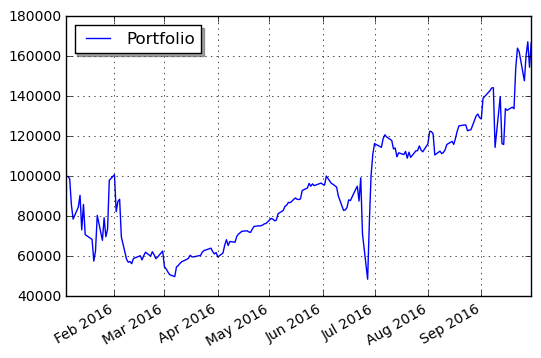

In [26]:
plt.plot()

## TODO: Output the ATM option given 45 days out; Output the IV; Output the 15-day delta 15 iron condor chain; trade the 15-day delta 15 iron condor, hold 'till expiration; trade the 45-day delta 15 iron condor over the course of a year

## TO-DO: Resolve the Call-Side Bug; Clean the Data; http://www.ivolatility.com/doc/deltasurfacemethodology.pdf
https://arxiv.org/pdf/1107.1834.pdf